Author: Lijing Wang, lijing52@stanford.edu; David Yin, yinzhen@stanford.edu; Jef Caers, jcaers@stanford.edu (2021)

In [30]:
## Clone data from our GitHub repository
! git clone https://github.com/lijingwang/GEOLSCI6_EARTHSYS100A.git

fatal: destination path 'GEOLSCI6_EARTHSYS100A' already exists and is not an empty directory.


In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
warnings.filterwarnings("ignore")

In this notebook, we will cover logistic regression and how to use logistic regression to predict the probability of a event. We will notice that the log odds ratio we learned in the previous notebook is extremely helpful for us to understand the logistic regression. 




# Binary classification problem

Logistic regression is used to model and predict the probability of a event. In practice, what we really observe is a binary dataset for a event, such as rain (1) no rain(0), landslide(1) no landslide(0), heart disease (1) no heart disease(0). 

We often have other independent variables which can inform this binary dependent variable. For example, in landslide prediction, the rainfall or the slope of a location will be helpful to estimate the landslide susceptibility, also known as the probability of having landslide in this location. Large rains and steep slopes will increase the landslide risk. 

Let's start with a simple example, with only one independent variable (univariate): age vs a binary event, heart disease. 


We document 1) all patients'age if they visit hospital with heart discomforts and 2) their final heart disease diagnosis. 

In [32]:
# load heart disease dataset
heart_disease_dataset = pd.read_csv('/content/GEOLSCI6_EARTHSYS100A/SpatialAggregation/LogisticRegression/heart_disease.csv',sep = ',')

In [33]:
heart_disease_dataset.head()

,age,heart_disease
0,54,0
1,43,0
2,47,0
3,57,0
4,54,0


Text(0, 0.5, 'Heart disease')

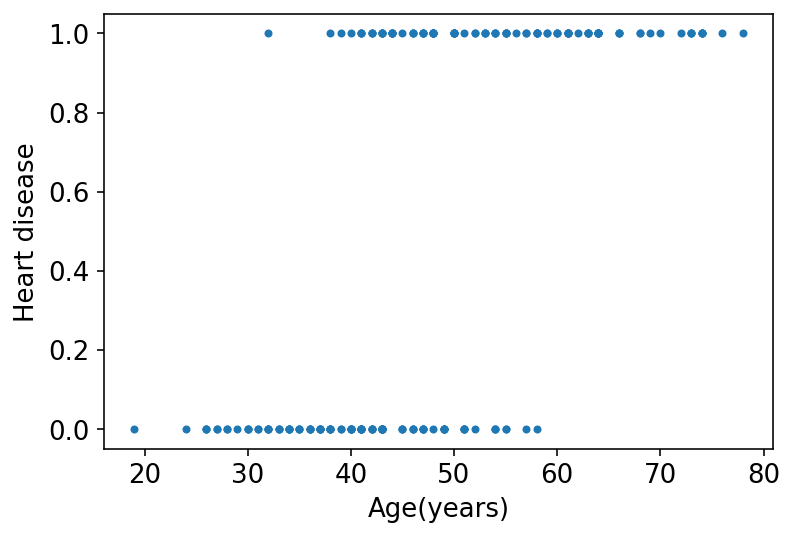

In [34]:
plt.plot(heart_disease_dataset['age'],heart_disease_dataset['heart_disease'],'.')
plt.xlabel('Age(years)')
plt.ylabel('Heart disease')

0 means no heart disease. 1 means with heart disease. We noticed that young people tends to have lower risk of heart disease. Can we quantify this observation? Given the age, can we calculate the probability of having heart disease? 

## Empirical conditional mean $E(\text{heart disease|age})$

Here we simply estimate the empirical probability given age. We calculate the probability of having heart disease for different age groups: 




In [35]:
## calculate the empirical conditional mean
conditional_mean = np.zeros(7)
num_people = np.zeros(7)
num1 = np.zeros(7)
num0 = np.zeros(7)
age_interval = np.linspace(20,80,num = 7)
for i, age in enumerate(age_interval):
    index = np.abs(heart_disease_dataset['age']-age)<=5
    num_people[i] = np.sum(index)
    num1[i] = np.sum(heart_disease_dataset['heart_disease'][index]==1)
    num0[i] = np.sum(heart_disease_dataset['heart_disease'][index]==0)
    conditional_mean[i] = np.mean(heart_disease_dataset['heart_disease'][index])

In [36]:
pd.DataFrame(np.vstack([num_people, num0, num1, np.round(conditional_mean,2)]).T, 
             columns = ['number of samples','heart disease(0)','heart disease(1)','Conditional mean E(heart disease|age)'],
             index = ['15-25','25-35','35-45','45-55','55-65','65-75','75-85'])

,number of samples,heart disease(0),heart disease(1),Conditional mean E(heart disease|age)
15-25,2.0,2.0,0.0,0.00
25-35,28.0,27.0,1.0,0.04
35-45,68.0,49.0,19.0,0.28
45-55,60.0,26.0,34.0,0.57
55-65,38.0,4.0,34.0,0.89
65-75,15.0,0.0,15.0,1.00
75-85,2.0,0.0,2.0,1.00


This probability is also known as a conditional mean $E(\text{heart disease|age}) = E(Y|x)$. The heart disease probability has increased with the age. 

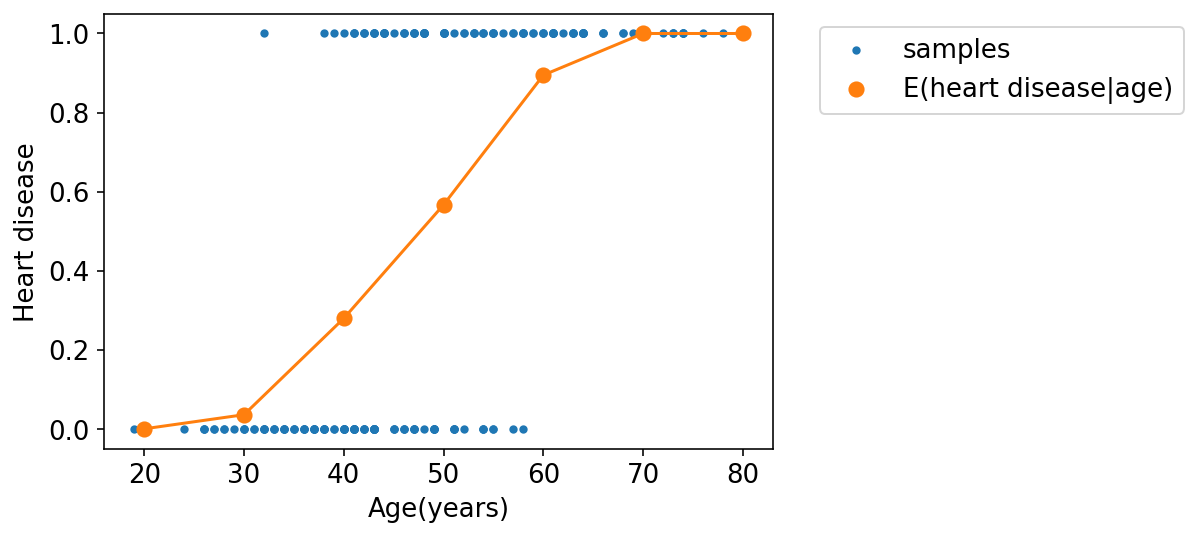

In [37]:
plt.scatter(heart_disease_dataset['age'],heart_disease_dataset['heart_disease'],s = 10, label = 'samples')
plt.scatter(age_interval,conditional_mean,s = 50, label = 'E(heart disease|age)')
plt.plot(age_interval,conditional_mean, color = 'C1')
plt.xlabel('Age(years)')
plt.ylabel('Heart disease')
plt.legend(bbox_to_anchor=(1.05, 1))

If we find a model to fit this empirical conditional mean, with the 'S' shape. We can then predict the heart disease probability for any age. 

Think about this 'S' shape. Did you recall anything we learned in the previous notebook? 

In [38]:
def logit(x):
    return np.log(x/(1-x))

Text(0.5, 0, 'Log odds ratio: logit(Y)')

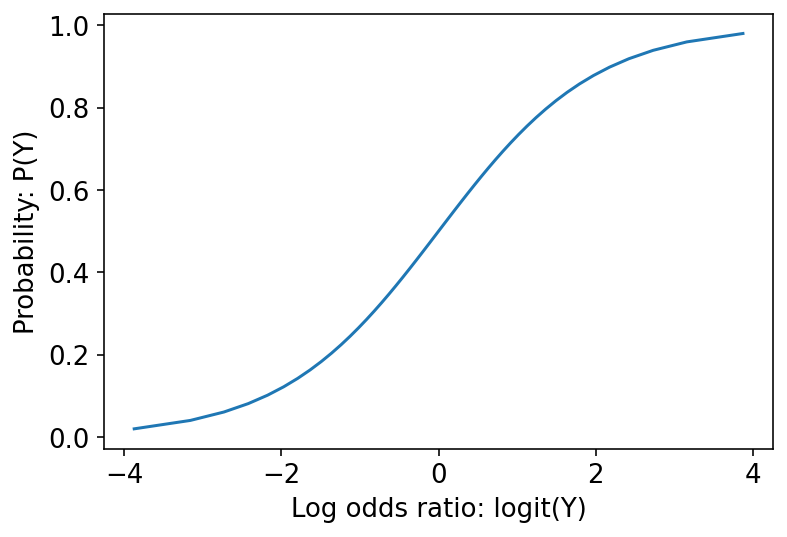

In [39]:
P = np.linspace(0,1) # probability
r = logit(P) # log odds ratio

plt.plot(r,P)
plt.ylabel('Probability: P(Y)')
plt.xlabel('Log odds ratio: logit(Y)')

Again our probability has been constrained within (0,1). We can easily use the logit transformation to open our probability space: 
$$\text{logit}(Y) = \log(\frac{P(Y)}{1-P(Y)})$$

Then the $\text{logit}(Y)$ and $x$ have linear relationship: 

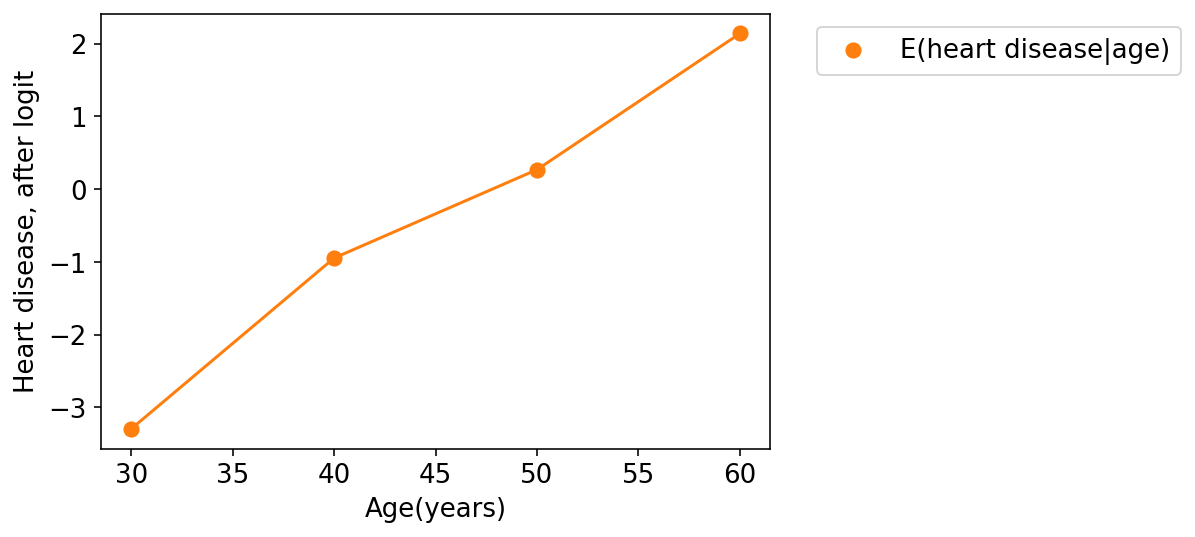

In [40]:
plt.scatter(age_interval,logit(conditional_mean),s = 50, label = 'E(heart disease|age)', color = 'C1')
plt.plot(age_interval,logit(conditional_mean), color = 'C1')
plt.xlabel('Age(years)')
plt.ylabel('Heart disease, after logit')
plt.legend(bbox_to_anchor=(1.05, 1))

## Why does linear regression not work? 

The first model we learned in statistics is linear regression. Does this simple model work for binary classification prediction? 

$$Y = \beta_0+\beta_1x$$

In [41]:
import statsmodels.formula.api as smf
linear_reg = smf.ols(formula='heart_disease ~ age', data=heart_disease_dataset)
linear_reg = linear_reg.fit()

In [42]:
print(linear_reg.summary())

                            OLS Regression Results                            
Dep. Variable:          heart_disease   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     135.6
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           3.30e-24
Time:                        19:09:48   Log-Likelihood:                -92.997
No. Observations:                 200   AIC:                             190.0
Df Residuals:                     198   BIC:                             196.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7614      0.112     -6.814      0.0

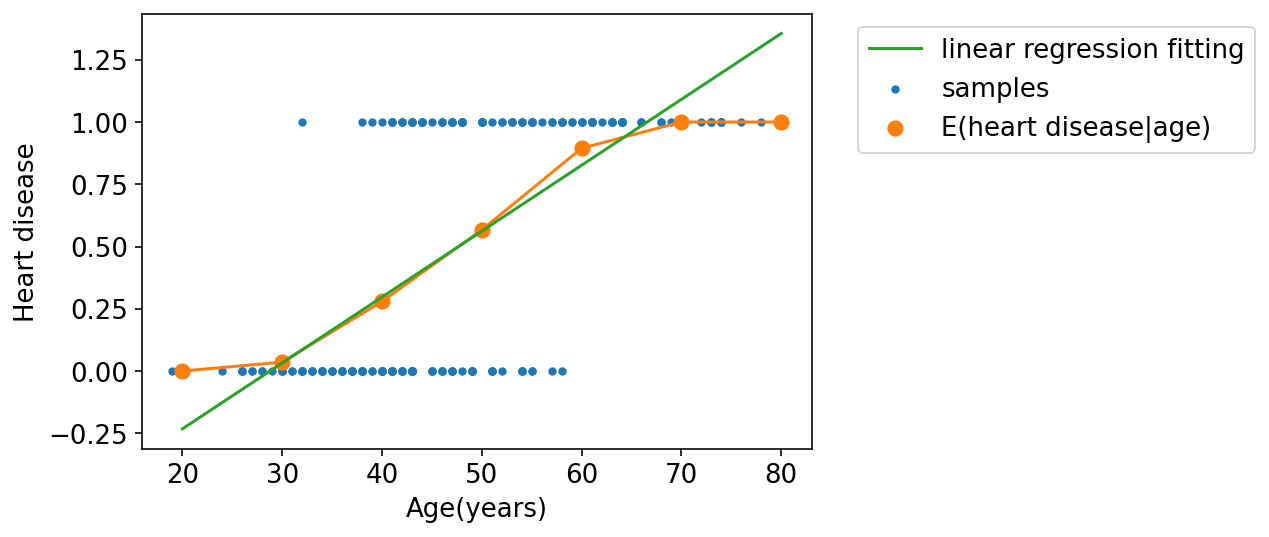

In [43]:
plt.scatter(heart_disease_dataset['age'],heart_disease_dataset['heart_disease'],s = 10, label = 'samples')
plt.scatter(age_interval,conditional_mean,s = 50, label = 'E(heart disease|age)')
plt.plot(age_interval,conditional_mean, color = 'C1')
plt.plot(np.linspace(20,80,num = 100),linear_reg.predict(exog=dict(age=np.linspace(20,80,num = 100))),label = 'linear regression fitting',color= 'C2')
plt.xlabel('Age(years)')
plt.ylabel('Heart disease')
plt.legend(bbox_to_anchor=(1.05, 1))

This linear model fits the conditional mean well for middle age groups. But the linear regression has no constraint on $Y$. Therefore $Y$ can be any value between $(-\infty, +\infty)$, which is not meaningful for the probability prediction. 

# Logistic Regression

Linear regression does not work. But we do notice there is a linear relationship between $\text{logit}(Y)$ and $x$. 

Logistic regression is simply to fit a linear regression model between $\text{logit}(Y)$ and $x$. 

## Fit a logistic regression model 

Fit a linear regression model on $\text{logit}(Y)$:

$$\text{logit}(Y) = \beta_0+\beta_1x$$

$$P(Y) = \frac{1}{1+\exp(-(\beta_0+\beta_1x))}$$



In [44]:
logit_reg = smf.logit(formula='heart_disease ~ age', data=heart_disease_dataset)
logit_reg = logit_reg.fit()

print(logit_reg.summary())

Optimization terminated successfully.
         Current function value: 0.433019
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          heart_disease   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Feb 2021   Pseudo R-squ.:                  0.3753
Time:                        19:09:48   Log-Likelihood:                -86.604
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                 1.972e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.6833      1.238     -7.013      0.000     -11.110      -6.257
age            0.1850      0.

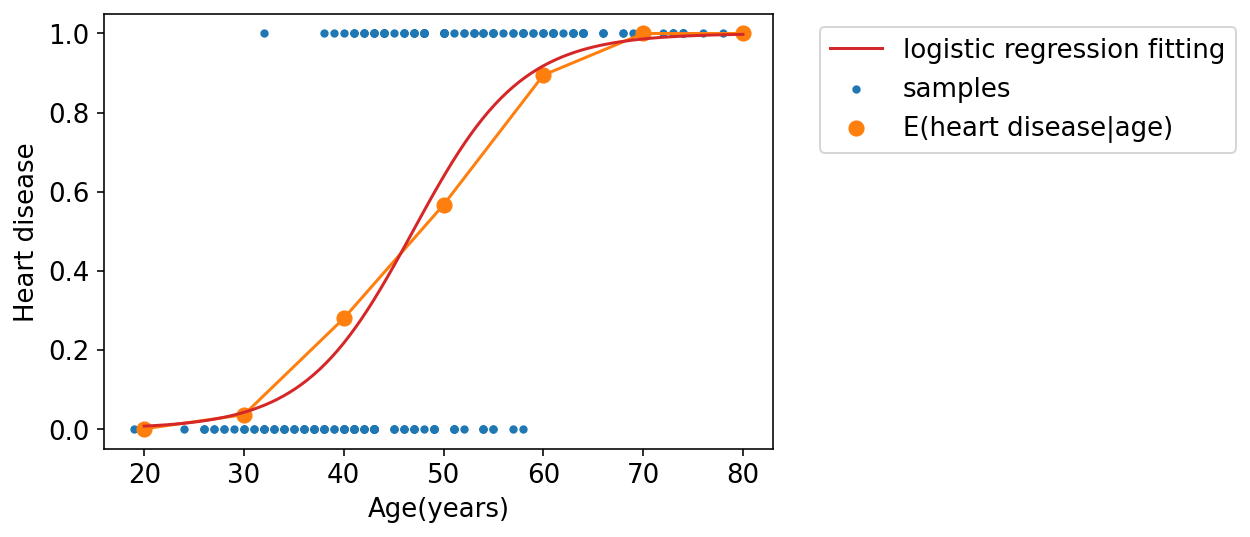

In [45]:
plt.scatter(heart_disease_dataset['age'],heart_disease_dataset['heart_disease'],s = 10, label = 'samples')
plt.scatter(age_interval,conditional_mean,s = 50, label = 'E(heart disease|age)')
plt.plot(age_interval,conditional_mean, color = 'C1')
plt.plot(np.linspace(20,80,num = 100),logit_reg.predict(exog=dict(age=np.linspace(20,80,num = 100))),label = 'logistic regression fitting',color= 'C3')
plt.xlabel('Age(years)')
plt.ylabel('Heart disease')
plt.legend(bbox_to_anchor=(1.05, 1))

The logistic regression predicts well for the conditional mean of all age groups.

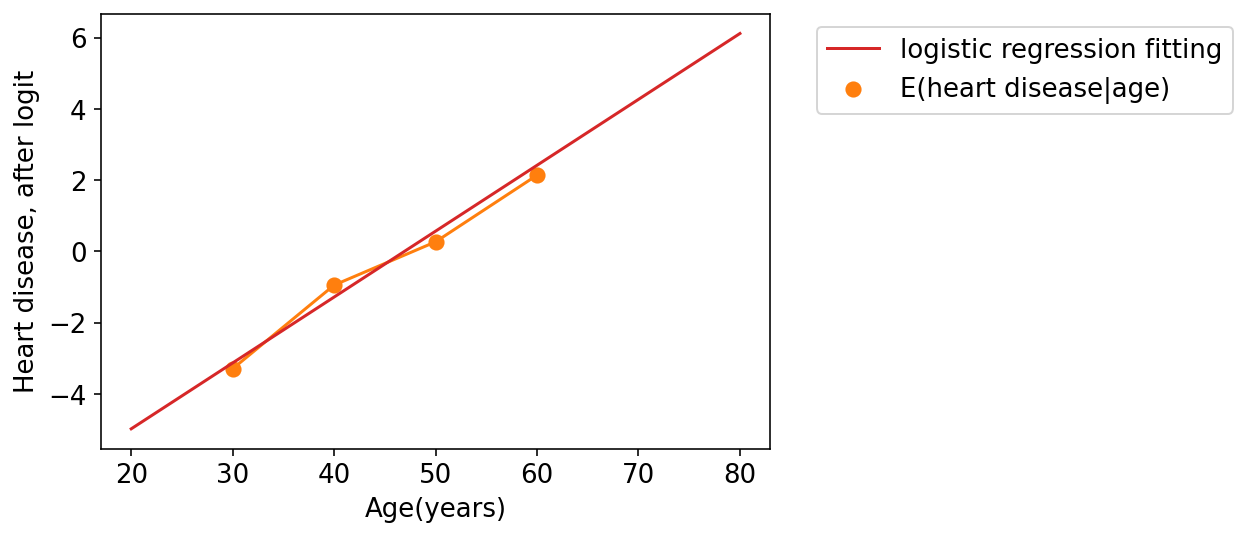

In [46]:
plt.scatter(age_interval,logit(conditional_mean),s = 50, label = 'E(heart disease|age)', color = 'C1')
plt.plot(age_interval,logit(conditional_mean), color = 'C1')
plt.plot(np.linspace(20,80,num = 100),logit(logit_reg.predict(exog=dict(age=np.linspace(20,80,num = 100)))),label = 'logistic regression fitting',color= 'C3')
plt.xlabel('Age(years)')
plt.ylabel('Heart disease, after logit')
plt.legend(bbox_to_anchor=(1.05, 1))

If we do logit transformation on the logistic regression predictions, we will see that the logistic regression is a linear regression in the domain of $x$ and $\text{logit}(Y)$. 

# Multivariate logistic regression: landslides susceptibility prediction in himalayas

For the heart disease case, we assume there is only one independent variable $x$: age. In many applications, we collect many independent variables $x_1, x_2, ..., x_p$ and intend to use them to predict the probability of an event $Y$. 



In this below dataset, we present the landslide map in himalayas: a binary map of landslide occurence. 0 means there was no landslide in this location, 1 means there was at least one landslide in this location. 

We also provide seven independent variables/predictors to predict the probability of landslide in each location:

- [Elevation](https://en.wikipedia.org/wiki/Elevation)
- [Aspect](https://en.wikipedia.org/wiki/Aspect_(geography)) 
- [Slope](https://en.wikipedia.org/wiki/Slope#Slope_of_a_road_or_railway)
- [Hillslope wetness ](https://en.wikipedia.org/wiki/Topographic_wetness_index)
- [NDVI (normalized difference vegetation index)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)
- [NDWI (normalized difference water index)](https://en.wikipedia.org/wiki/Normalized_difference_water_index)
- [Curvature](https://en.wikipedia.org/wiki/Curvature)



In [47]:
# load landslides dataset
# The domain has 150x270 pixels. Each column(vector)represents one predictor with length 40500 (270x150). You can reshape the vector to matrix 270x150. 

landslides_dataset = pd.read_csv('/content/GEOLSCI6_EARTHSYS100A/SpatialAggregation/LogisticRegression/landslides_himalaya.csv',sep = ',')

In [48]:
landslides_dataset.head()

,landslide,elevation,aspect,slope,wetness,ndvi,ndwi,curvature
0,0.0,5242.0,335.0,14.0,0.320446,-0.013182,0.606071,0.0
1,0.0,5718.0,8.0,21.0,0.376848,-0.048040,0.817809,-186.0
2,0.0,6008.0,85.0,12.0,0.376848,-0.025214,0.596792,-539.0
3,0.0,5759.0,181.0,15.0,0.376848,-0.032129,0.723321,-19.0
4,0.0,5491.0,191.0,14.0,0.376848,-0.029776,0.808161,52.0


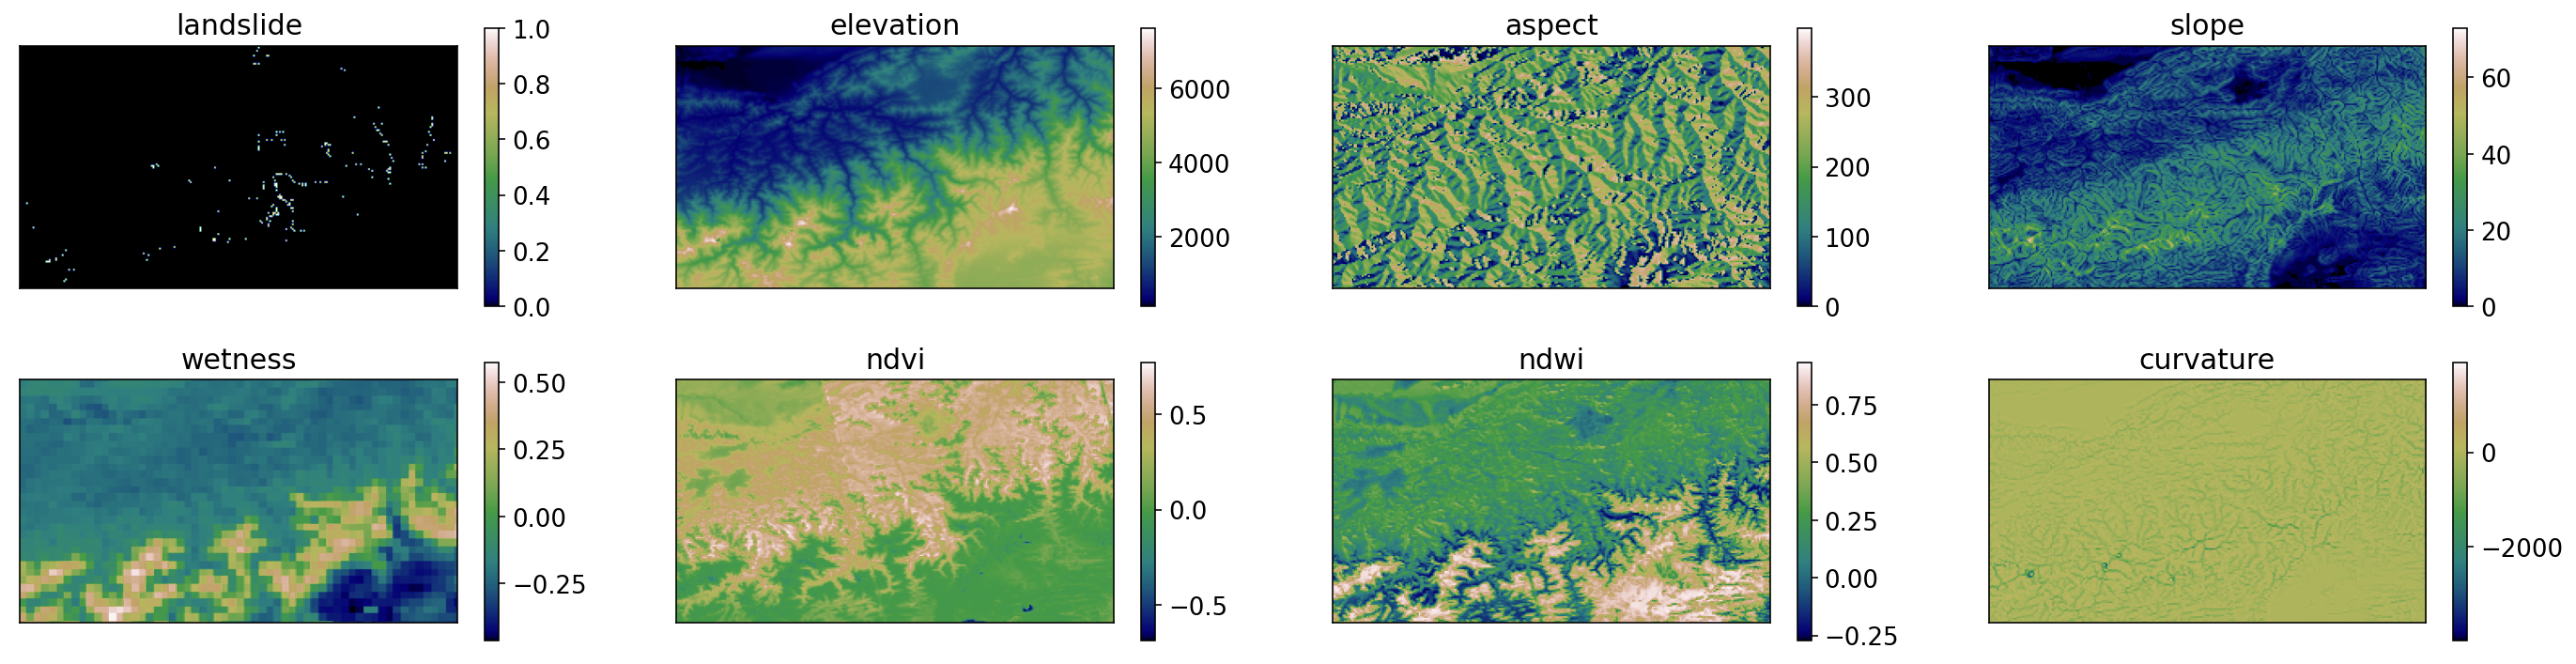

In [49]:
fig, axs = plt.subplots(2,4, figsize=(24, 6))
axs = axs.ravel()
for i in range(8):
    name = landslides_dataset.columns[i]
    plot = axs[i].imshow(landslides_dataset[name].values.reshape(270,150).T, origin = 'lower', cmap = 'gist_earth')
    plt.colorbar(plot,ax=axs[i])
    axs[i].set_title(name, fontsize = 15)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

## Fit a multivariate logistic regression model

If we have more than one predictor/independent variable, we can simply fit a multivariate linear regression model for $\text{logit}(Y)$. That's the multivariate logistic regression model:

$$\text{logit}(Y) = \beta_0+\beta_1x_1+ \beta_2x_2 +... + \beta_px_p$$

$$P(Y) = \frac{1}{1+\exp(-(\beta_0+\beta_1x_1+ \beta_2x_2 +... + \beta_px_p))}$$

In [50]:
logit_reg_landslide = smf.logit("landslide ~ elevation + aspect + slope + wetness + ndvi + ndwi + curvature", data=landslides_dataset)
logit_reg_landslide = logit_reg_landslide.fit()

Optimization terminated successfully.
         Current function value: 0.028051
         Iterations 11


## Explain the logistic regression result

Our null hypothesis in the logistic regression is: 


$$H_0: \beta_0 = 0, \beta_1 = 0, \beta_2 = 0,..., \beta_p = 0$$

Therefore, after we fit this logistic regression model, we will have the fitted coefficient values for $\beta_0, \beta_1, \beta_2,..., \beta_p$ and understand if these cofficients $\beta_0, \beta_1, \beta_2,..., \beta_p$ are deviated from our null hypothesis 0. 

In [51]:
print(logit_reg_landslide.summary())

                           Logit Regression Results                           
Dep. Variable:              landslide   No. Observations:                40500
Model:                          Logit   Df Residuals:                    40492
Method:                           MLE   Df Model:                            7
Date:                Wed, 24 Feb 2021   Pseudo R-squ.:                  0.1287
Time:                        19:09:52   Log-Likelihood:                -1136.1
converged:                       True   LL-Null:                       -1303.9
Covariance Type:            nonrobust   LLR p-value:                 1.394e-68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.8271      0.464    -16.884      0.000      -8.736      -6.918
elevation      0.0005   9.17e-05      5.105      0.000       0.000       0.001
aspect        -0.0037      0.001     -4.196      0.0

- **Coefficients**: $\beta_0, \beta_1, \beta_2,..., \beta_p$ These cofficients tell us about the relationship between the independent variables (i.e. slope) and the dependent variable (the landslide occurence). For example, for the slope, we have cofficient = 0.0452, which is positive. That means a steeper slope has a higher landslide risk. 
- **z and P-value**(P>|z|): z is the statistics to test if the cofficient is 0 thereby if our null hypothesis is rejected or not. P-value tells us the probability of this coefficient under the assumption that the null hypothesis is correct $\beta_i = 0$ A small p-value (less than 0.01 or 0.05) means that this cofficient would be very unlikely under the null hypothesis. So if the p-value is small, then we know that our variable is meaningful in this model, or a new term is "statistically significant". So in this case, only 'wetness' and 'curvature' are having large p-values, and not statistically significant. 
- **95$\%$ of confidence interval** for the coefficients: [0.025,0.975]. Our assumption is that the parameters $\beta_0, \beta_1, \beta_2,..., \beta_p$ are not 0. So if the confidence interval includes 0, that also indicates that coefficient is not statistically significant, such as 'wetness' and 'curvature'. 
- **Log-likelihood**: the goodness of fit of one logistic regression model to the dataset. It can be used to compare different logistic regression models. The higher log-likelihood is, the better our model fits. For example, we can remove slope, and fit the logistic regression again: 

In [52]:
logit_reg_landslide2 = smf.logit("landslide ~ elevation + aspect + wetness + ndvi + ndwi + curvature", data=landslides_dataset)
logit_reg_landslide2 = logit_reg_landslide2.fit()

Optimization terminated successfully.
         Current function value: 0.028337
         Iterations 11


In [53]:
print(logit_reg_landslide2.summary())

                           Logit Regression Results                           
Dep. Variable:              landslide   No. Observations:                40500
Model:                          Logit   Df Residuals:                    40493
Method:                           MLE   Df Model:                            6
Date:                Wed, 24 Feb 2021   Pseudo R-squ.:                  0.1198
Time:                        19:09:52   Log-Likelihood:                -1147.7
converged:                       True   LL-Null:                       -1303.9
Covariance Type:            nonrobust   LLR p-value:                 1.670e-64
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.6577      0.454    -16.882      0.000      -8.547      -6.769
elevation      0.0006   8.44e-05      7.148      0.000       0.000       0.001
aspect        -0.0036      0.001     -4.107      0.0

Then the log-likelihood without slope is -1147.7, which is lower than with slope -1136.1. Therefore, we prefer to keep "slope" variable in our logistic regression for better fitting. In fact, that is one of the variable selection techniques. We can perform the same analysis for all variables and see if we should keep them in our model or not. 

## Compare the prediction result with the binary occurence map

The landslide probability prediction using logistic regression: 

Text(0.5, 1.0, 'Landslides susceptibility prediction')

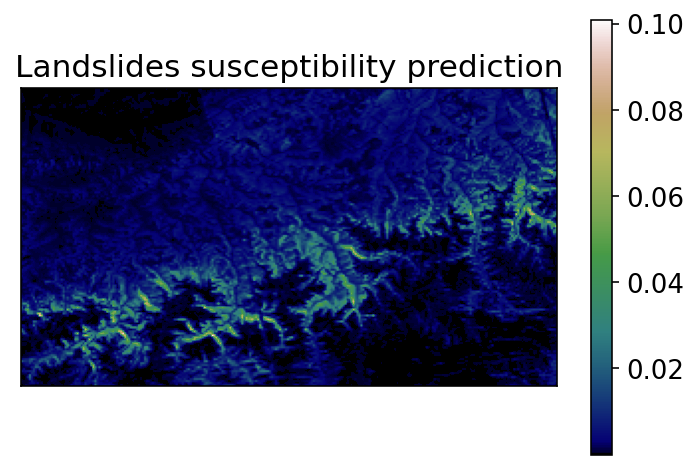

In [54]:
plt.imshow(logit_reg_landslide.predict().reshape(270,150).T, origin = 'lower', cmap = 'gist_earth')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Landslides susceptibility prediction')

Higher probability area is with higher slope and locates within the valley.

 Here we just have the probability prediction. What if we would like to compare the prediction with the binary occurence map? We need a threshold to turn this probability map into a binary map. 

Let's random pick a threshold = 0.03:

Text(0.5, 1.0, '> 0.03')

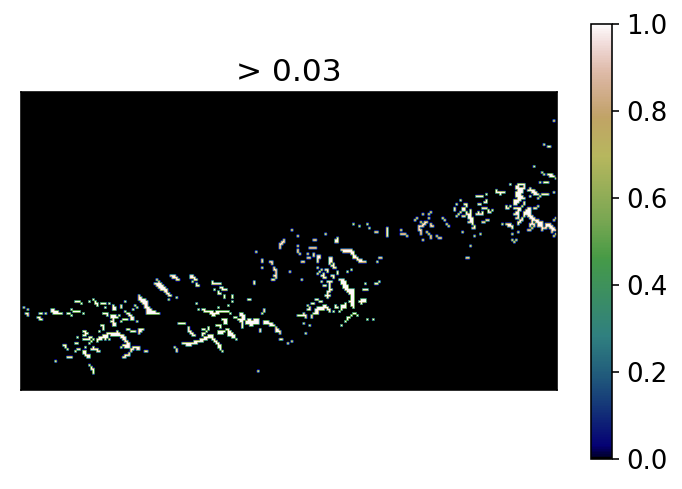

In [55]:
threshold = 0.03
plt.imshow(logit_reg_landslide.predict().reshape(270,150).T>threshold, origin = 'lower', cmap = 'gist_earth')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('> '+str(threshold))

Text(0.5, 1.0, 'landslides occurence')

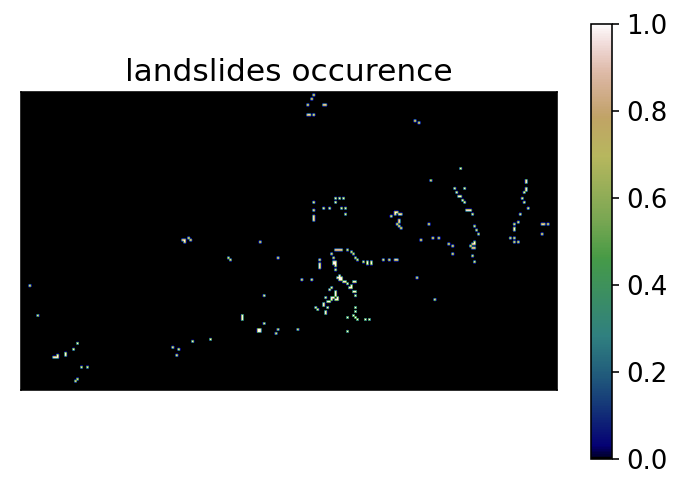

In [56]:
plt.imshow(landslides_dataset['landslide'].values.reshape(270,150).T, origin = 'lower', cmap = 'gist_earth')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('landslides occurence')

### Confusion matrix

We can compare these two binary maps using the confusion matrix. Confusion matrix is a table with two rows and two columns that reports the number of false positives, false negatives, true positives, and true negatives.

|      |   |   Prediction   |                |
|:----:|:-:|:--------------:|:--------------:|
|      |   |        0       |        1       |
| True | 0 |  True Negative | False Positive |
|      | 1 | False Negative |  True Positive |

- True Positive (TP): the truth is positive (1), and the prediction is positive (1). 
- True Negative (TN): the truth is negative (0), and the prediction is negative (0). 
- False Negative (FN): the truth is positive (1), and the prediction is negative (0). 
- False Positive (FP): the truth is negative (0), and the prediction is positive (1). 

Text(0.5, 1.0, 'No normalization')

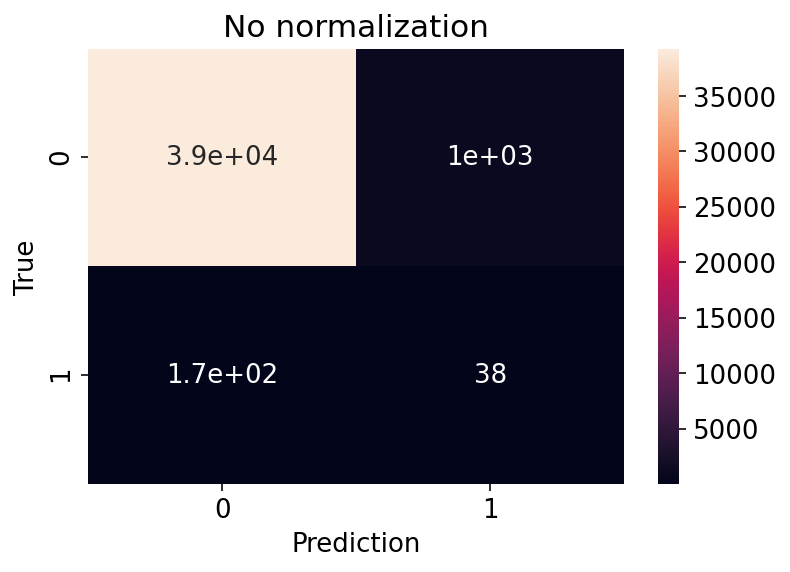

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(landslides_dataset['landslide'].values, logit_reg_landslide.predict()>threshold, normalize= None)
sns.heatmap(cm, annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('No normalization')

Can you explain this confusion matrix in the landslide context?  

We can also normalize these confusion matrix by the number of positive and the number of negative in the truth: 

Text(0.5, 1.0, 'Normalized')

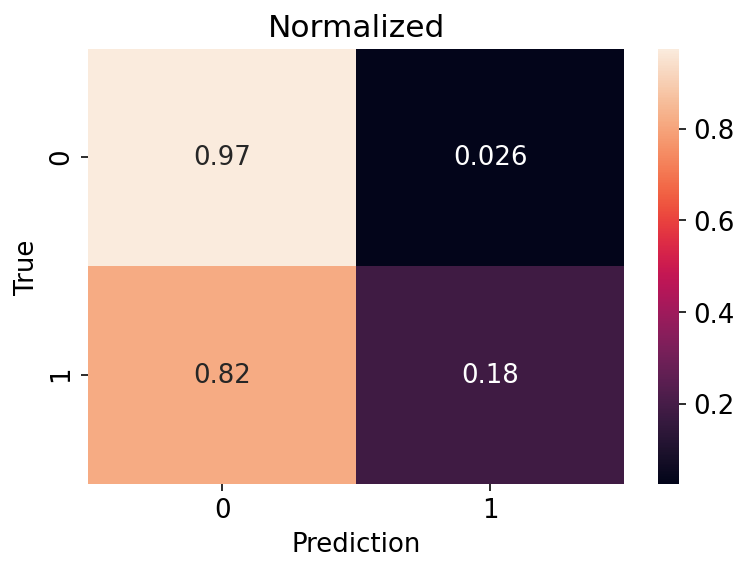

In [58]:
import seaborn as sns
cm = confusion_matrix(landslides_dataset['landslide'].values, logit_reg_landslide.predict()>threshold, normalize= 'true')
sns.heatmap(cm, annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Normalized')

If you change the threshold, you will have different binary maps and different confusion matrix. The choice of this threshold will have an impact in the trade-offs of positive and negative errors.

Any ideas on how to find a optimal threshold? (If you are interested in this question, you can check [the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic))